<h2>Prototype</h2>

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import get_window
from scipy.io import wavfile
import IPython

In [4]:
fs, x = wavfile.read("sawtooth.wav")
x = x / np.max(abs(x))

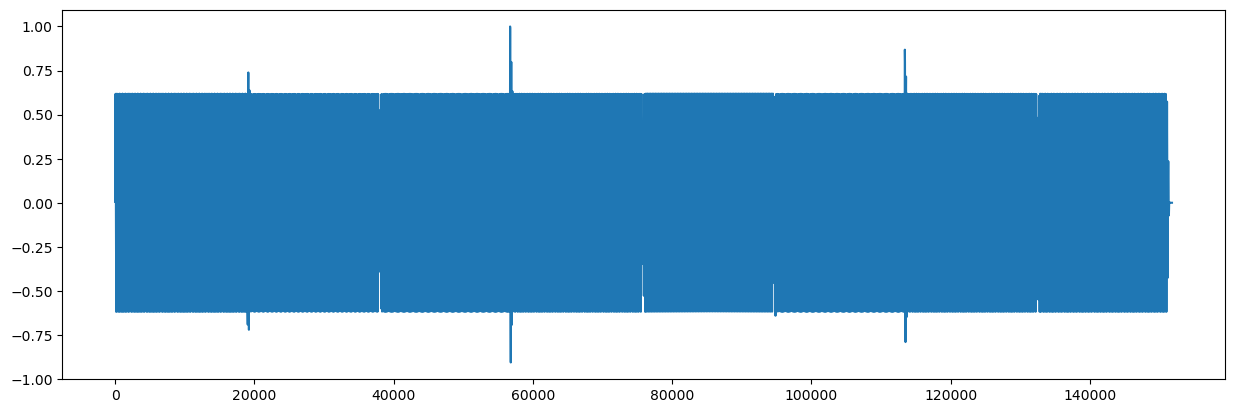

In [5]:
plt.figure().set_figwidth(15)
plt.plot(x)
IPython.display.Audio(x, rate=fs)

In [6]:
M=8001
N=8192
H=256

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [7]:
w  = get_window('blackman', M)
w = w / sum(w)

In [8]:
def computeSpectrum(x):
    spectrum = []

    l = 0
    while l < len(x) - M:
        y = x[l: l + M] * w

        fftBuffer = np.zeros(N)
        fftBuffer[: hM1] = y[hM2:] 
        fftBuffer[N - hM2:] = y[: hM2]

        X = fft(fftBuffer)
        absX = abs(X)
        absX[absX < np.finfo(float).eps] = np.finfo(float).eps
        mX = 20 * np.log10(absX)
        spectrum.append(mX)

        l += H
    
    return spectrum

In [9]:
spectrum = computeSpectrum(x)

In [10]:
t = np.arange(len(spectrum)) * H / fs
fqs = np.arange(N) * fs / N
f = int(2500 * N / fs)

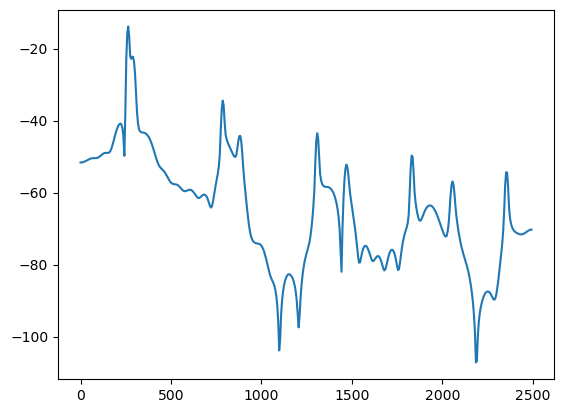

In [11]:
plt.plot(fqs[:f], spectrum[210][:f])

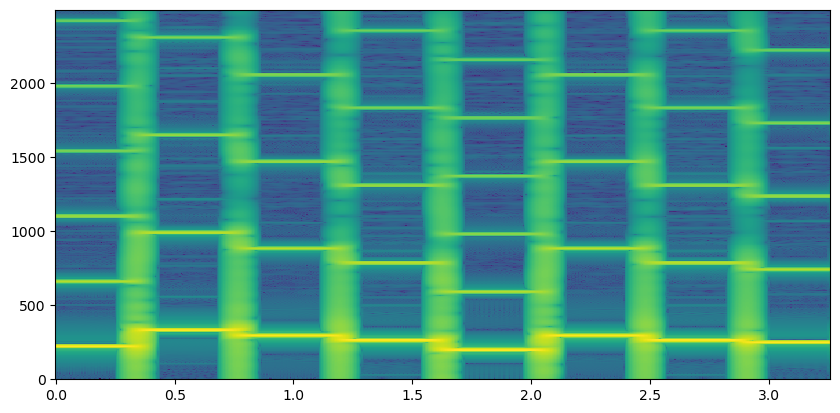

In [12]:
f = int(2500 * N / fs)
spectrum = np.array(spectrum)
plt.figure().set_figwidth(10)
fqs = np.arange(N) * fs / N
plt.pcolormesh(t, fqs[:f], spectrum.T[:f])

In [13]:
peaks_k = []
peaks_mX = []

for i in range(len(spectrum)):
    ks = []
    mXs = []
    for j in range(1, int(f)):
        #print(spectrum[i][j])
        if spectrum[i][j] < -40: continue
            
        elif spectrum[i][j-1] < spectrum[i][j] and spectrum[i][j] > spectrum[i][j+1]:
            ks.append(j * fs / N)
            mXs.append(spectrum[i][j])
    
    peaks_k.append(ks)
    peaks_mX.append(mXs)

In [14]:
peaks_k[0]

[220.71533203125, 662.14599609375]

In [15]:
peaks_mX[300]

[-12.666415584448412, -31.267576536766075, -39.94162262928763]

In [16]:
fundamentals = []
for i in range(len(peaks_k)):
    candidates = []
    
    num = len(peaks_k[i])
    if num == 0:
        continue
    elif num == 1:
        f0 = peaks_k[i][0]
        fundamentals.append(f0)
        continue
        
    elif num == 2:
        f0 = peaks_k[i][1] - peaks_k[i][0]
        fundamentals.append(f0)
        continue
    
    for j in range(num-1):
        #print(peaks_k[i][j+1] - peaks_k[i][j])
        candidates.append(peaks_k[i][j+1] - peaks_k[i][j])
        
    f0 = candidates[0]
    least_err = 99999
        
    for fr in candidates:
        errpm = 0
        errmp = 0
        
        for j in range(num):
            errpm += (fr * (j+1) - peaks_k[i][j]) * (fr * (j+1))**(-0.5) + peaks_mX[i][j] / max(peaks_mX[i]) * (1.4 * (fr * (j+1) - peaks_k[i][j]) * (fr * (j+1))**(-0.5) - 0.5)
            errmp += (fr * (j+1) - peaks_k[i][j]) * (peaks_k[i][j])**(-0.5) + peaks_mX[i][j] / max(peaks_mX[i]) * (1.4 * (fr * (j+1) - peaks_k[i][j]) * (peaks_k[i][j])**(-0.5) - 0.5)
        
        err_tot = (errpm + errmp) / num
        if err_tot < least_err:
            least_err = err_tot
            f0 = fr
    
    fundamentals.append(f0)

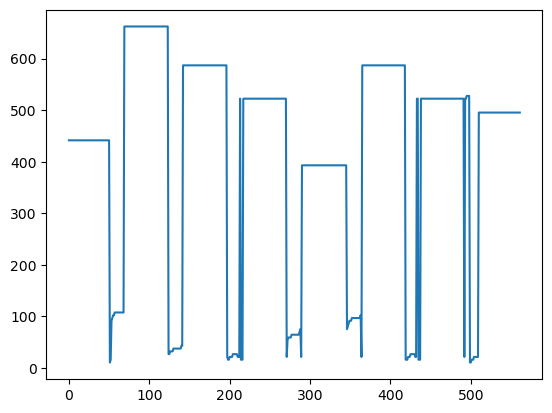

In [17]:
plt.plot(fundamentals)

<h4>Needs a nueral network to identify the peaks</h4>

In [18]:
notes = [69 + 12 * np.log2(f0 / 440) for f0 in fundamentals]

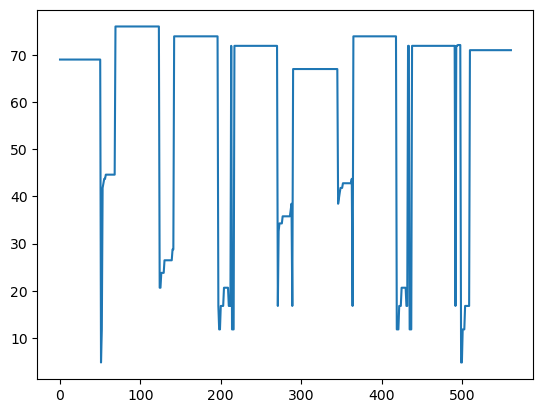

In [19]:
plt.plot(notes)

In [21]:
stddeviations = []

for i in range(len(notes)):
    if i < 3:
        stddeviations.append(np.std(notes[0:i + 1]))
    else:
        stddeviations.append(np.std(notes[i - 5: i + 1]))

stableNotes = []

for i in range(len(stddeviations)):
    if stddeviations[i] < 10:
        stableNotes.append(i);
        
segments = []
i = 1
beg = stableNotes[0]
while i < len(stableNotes):
    while i < len(stableNotes):
        if stableNotes[i - 1] != stableNotes[i] - 1:
            end = stableNotes[i - 1]
            break
        elif i == len(stableNotes) - 1:
            end = stableNotes[i]
            break
        i += 1

    segments.append((beg, end))

    beg = stableNotes[i]
    i += 1

seq = []
for i in range(len(segments)):
    if notes[segments[i][0]] < 50:
        continue
    seq.append(np.round(notes[segments[i][0]]))

In [22]:
print(seq)

[69.0, 69.0, 76.0, 74.0, 72.0, 67.0, 74.0, 72.0, 72.0, 71.0]


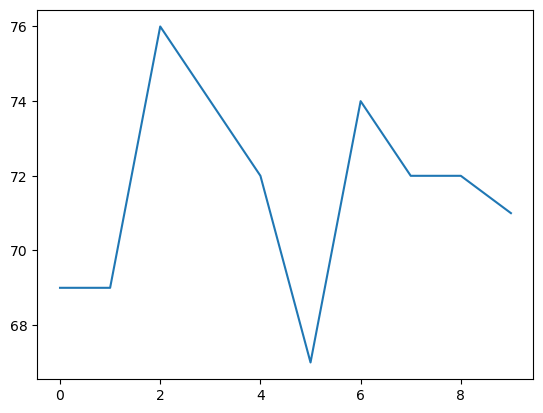

In [23]:
plt.plot(seq)